# this is a script to test the input in serial in live with python

In [1]:
import serial
import numpy as np

In [2]:
import serial
import time
COM = 17
# Set up the serial connection (make sure the port matches your setup)
ser = serial.Serial(f'COM{COM}', 9600)  # For Windows
# ser = serial.Serial('/dev/ttyUSB0', 9600)  # For Linux
# ser = serial.Serial('/dev/tty.usbmodem1411', 9600)  # For macOS

# Allow some time for the connection to establish
time.sleep(2)

try:
    if ser.in_waiting > 0:
        line = ser.readline().decode('utf-8').rstrip()
        print(f"Received: {line}")
except KeyboardInterrupt:
    print("Exiting...")

finally:
    ser.close()


Received: -0.26	1.01	-0.00	-1	1	90.18	104.72	-360	360


## 5 second snap

Data logging...
Done


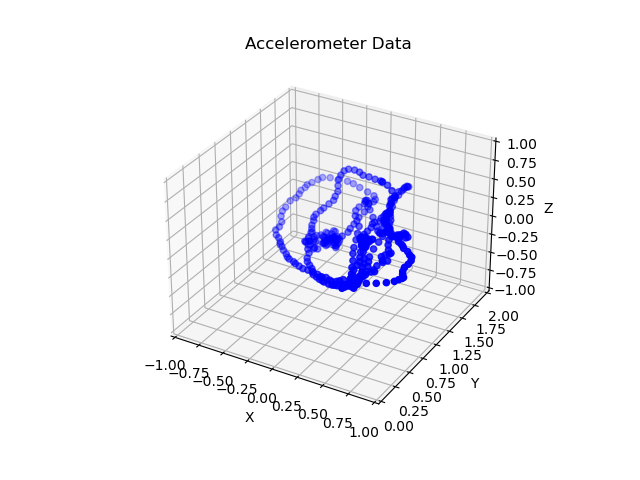

In [5]:
import serial
import time
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from mpl_toolkits.mplot3d import Axes3D

# Set up the serial connection (make sure the port matches your setup)
ser = serial.Serial('COM17', 9600)  # For Windows
# ser = serial.Serial('/dev/ttyUSB0', 9600)  # For Linux
# ser = serial.Serial('/dev/tty.usbmodem1411', 9600)  # For macOS

# Allow some time for the connection to establish
time.sleep(2)

# Collect data from serial port for 5 seconds
duration = 5  # in seconds
start_time = time.time()
x_data, y_data, z_data = [], [], []
print("Data logging...")
while time.time() - start_time < duration:
    if ser.in_waiting > 0:
        line = ser.readline().decode('utf-8').rstrip()
        try:
            x, y, z, _, _ , t, p, _, _ = map(float, line.split('\t'))
            x_data.append(x)
            y_data.append(y)
            z_data.append(z)
        except ValueError:
            pass  # Handle the case where the serial input is not valid
print("Done")
# Close the serial connection
ser.close()

# Create a figure and a 3D axis
%matplotlib widget
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Initialize the plot
ax.scatter(-np.array(z_data), y_data, x_data, c='b', marker='o')
ax.set_xlim(-1, 1)
ax.set_ylim(0, 2)
ax.set_zlim(-1, 1)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.title('Accelerometer Data')

plt.show()


In [ ]:
import serial
import plotly.graph_objects as go
import pandas as pd
from plotly.subplots import make_subplots
from IPython.display import display
import time

# Initialize serial port
ser = serial.Serial('COM17', 2400)

# Set the number of points to display
N = 60

# Create a subplot figure
fig = make_subplots(rows=3, cols=1, shared_xaxes=True,
                    subplot_titles=("Accelerometer X", "Accelerometer Y", "Accelerometer Z"))

# Initialize traces
trace_x = go.Scatter(y=[], mode='lines', name='AcX')
trace_y = go.Scatter(y=[], mode='lines', name='AcY')
trace_z = go.Scatter(y=[], mode='lines', name='AcZ')

# Add traces to the figure
fig.add_trace(trace_x, row=1, col=1)
fig.add_trace(trace_y, row=2, col=1)
fig.add_trace(trace_z, row=3, col=1)

# Set y-axis limits
y_min = -2  # Example minimum value
y_max = 2   # Example maximum value
fig.update_yaxes(range=[y_min, y_max], row=1, col=1)
fig.update_yaxes(range=[y_min, y_max], row=2, col=1)
fig.update_yaxes(range=[y_min, y_max], row=3, col=1)

fig.update_layout(title_text="Live Accelerometer Data", height=800)

# Use FigureWidget for interactive updates
fig_widget = go.FigureWidget(fig)

# Display the figure widget
display(fig_widget)

def update_plot():
    global time_data, AcX_data, AcY_data, AcZ_data
    time_data = []
    AcX_data = []
    AcY_data = []
    AcZ_data = []
    while True:
        try:
            line = ser.readline().decode('utf-8').rstrip()
            x, y, z, _, _ , t, p, _, _ = map(float, line.split('\t'))
            parts = [x,y,z]
            if len(parts) == 3:
                AcX_val = float(parts[0])
                AcY_val = float(parts[1])
                AcZ_val = float(parts[2])

                time_data.append(pd.Timestamp.now())
                AcX_data.append(AcX_val)
                AcY_data.append(AcY_val)
                AcZ_data.append(AcZ_val)

                # Keep only the latest N data points
                time_data = time_data[-N:]
                AcX_data = AcX_data[-N:]
                AcY_data = AcY_data[-N:]
                AcZ_data = AcZ_data[-N:]

                with fig_widget.batch_update():
                    fig_widget.data[0].y = AcX_data
                    fig_widget.data[1].y = AcY_data
                    fig_widget.data[2].y = AcZ_data

                # time.sleep(0.1)  # Adjust the delay as necessary
        except KeyboardInterrupt:
            ser.close()
            break

# Run the update function
update_plot()


FigureWidget({
    'data': [{'mode': 'lines',
              'name': 'AcX',
              'type': 'scatter',
  …